In [1]:
# Impor semua pustaka yang akan kita gunakan
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Atur agar TensorFlow tidak menampilkan terlalu banyak pesan log
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

print("TensorFlow Version:", tf.__version__)
print("Semua pustaka berhasil diimpor.")

2025-09-20 08:20:11.841107: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-20 08:20:11.897430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 08:20:13.332063: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


TensorFlow Version: 2.20.0
Semua pustaka berhasil diimpor.


In [2]:
# --- KONFIGURASI PATH ---
BASE_PATH = "." # GANTI INI dengan lokasi folder proyek Anda jika berbeda

BASE_IMAGE_DIR = os.path.join(BASE_PATH, "dataset_gambar_3komponen/")
CSV_DIR = os.path.join(BASE_PATH, "dataset_numerik/")

# Path Input (gunakan file CSV yang sudah divalidasi jika ada)
PRECURSOR_CSV_PATH = os.path.join(CSV_DIR, "hasil_fitur_precursor.csv")
NORMAL_CSV_PATH = os.path.join(CSV_DIR, "hasil_fitur_normal_terfilter.csv") 
# Path untuk data sintetik SMOTE yang baru Anda buat
SMOTE_SYNTHETIC_CSV_PATH = os.path.join(CSV_DIR, "hasil_fitur_sintetik_SMOTE.csv") 

# Path Output untuk model ini (akan berbeda agar tidak menimpa model sebelumnya)
MODEL_SAVE_PATH = os.path.join(BASE_PATH, "best_xception_smote_synthetic_model.keras")

# --- PARAMETER MODEL ---
IMG_SIZE = 128
BATCH_SIZE = 16 # Turunkan jika Anda mengalami error kehabisan memori (misal, ke 8)

print(f"Path utama proyek diatur ke: {os.path.abspath(BASE_PATH)}")
print("Catatan: Mode ini menggunakan DATA ASLI + DATA SINTETIK SMOTE.")

Path utama proyek diatur ke: /home/kmtr/Earthquake_Prediction
Catatan: Mode ini menggunakan DATA ASLI + DATA SINTETIK SMOTE.


In [3]:
print("--- Memuat dataset sumber (Data Asli + Sintetik SMOTE) ---")
try:
    df_precursor_original = pd.read_csv(PRECURSOR_CSV_PATH)
    df_normal_original = pd.read_csv(NORMAL_CSV_PATH)
    df_sintetik_smote = pd.read_csv(SMOTE_SYNTHETIC_CSV_PATH) # Baca data sintetik SMOTE
except FileNotFoundError as e:
    print(f"Eror: Pastikan file CSV sumber ada di lokasi yang benar. {e}")
    raise

# Beri label dan info folder untuk data asli
df_precursor_original['label'] = 1
df_precursor_original['image_folder'] = 'precursor'
df_normal_original['label'] = 0
df_normal_original['image_folder'] = 'normal'

# Beri label dan info folder untuk data sintetik SMOTE
# Untuk data SMOTE, kita akan mengasumsikan mereka adalah prekursor
# dan untuk path gambar, kita akan "meminjam" dari data prekursor asli.
# Setiap sampel SMOTE baru adalah unik secara numerik, tetapi secara gambar
# kita akan menggunakan gambar dari sampel prekursor asli yang cocok (berdasarkan logika Sel 5 dari notebook SMOTE)
# atau paling sederhana, mengulanginya secara acak.
# PENTING: Untuk demonstrasi ini, kita akan membuat placeholder 'path_Z', 'path_H', 'path_D'
# yang menunjuk ke gambar dari prekursor asli. Dalam implementasi yang lebih canggih,
# Anda mungkin perlu logika yang lebih rumit untuk mengasosiasikan gambar.
df_sintetik_smote['label'] = 1
df_sintetik_smote['image_folder'] = 'precursor' # Ini akan membantu di bagian validasi path

# --- PREPROCESSING UNTUK KOLOM METADATA SINTETIK ---
# Kolom 'Tanggal', 'Jam', 'Stasiun' di df_sintetik_smote saat ini diisi dengan nilai dari sampel asli secara acak.
# Pastikan tipe data mereka benar.
# Jika ada NaN di kolom ini (karena df_sintetik_smote dibuat dari fitur saja), isi dengan nilai default.
for col in ['Tanggal', 'Stasiun', 'Jam']:
    if col not in df_sintetik_smote.columns:
        # Jika kolom tidak ada, tambahkan dari df_precursor_original secara acak
        df_sintetik_smote[col] = df_precursor_original[col].sample(len(df_sintetik_smote), replace=True, random_state=42).values
    elif df_sintetik_smote[col].isnull().any():
        # Jika ada NaN, isi dengan modus (nilai paling sering muncul) dari data asli
        mode_val = df_precursor_original[col].mode()[0]
        df_sintetik_smote[col].fillna(mode_val, inplace=True)

# Pastikan kolom 'Tanggal' memiliki format string yang benar jika di Sel 5 SMOTE ada masalah
if 'Tanggal' in df_sintetik_smote.columns and pd.api.types.is_numeric_dtype(df_sintetik_smote['Tanggal']):
    df_sintetik_smote['Tanggal'] = df_sintetik_smote['Tanggal'].astype(int).astype(str)
# Asumsi 'Jam' juga perlu int
if 'Jam' in df_sintetik_smote.columns and pd.api.types.is_numeric_dtype(df_sintetik_smote['Jam']):
    df_sintetik_smote['Jam'] = df_sintetik_smote['Jam'].astype(int)

# Gabungkan semua data menjadi satu DataFrame besar untuk divalidasi
df_full_combined = pd.concat([df_precursor_original, df_normal_original, df_sintetik_smote], ignore_index=True)
print(f"Total entri data yang akan divalidasi (Asli + Sintetik): {len(df_full_combined)}")


print(f"\n--- Memvalidasi entri data terhadap file gambar ---")
valid_rows = []
for index, row in df_full_combined.iterrows():
    try:
        stasiun = row['Stasiun']
        jam = int(row['Jam'])
        if jam == 24: jam = 0 # Koreksi jam 24 menjadi 0
        
        # Untuk sampel asli, base_filename sama seperti sebelumnya.
        # Untuk sampel SMOTE, kita perlu strategi agar menunjuk ke gambar prekursor yang valid.
        # Pendekatan: Untuk data sintetik SMOTE, kita akan "meminjam" base_filename dari prekursor asli.
        # Ini berarti sampel numerik sintetik akan divisualisasikan menggunakan gambar dari prekursor asli.
        # Ini adalah kompromi yang umum ketika SMOTE digunakan pada data yang memiliki visualisasi.
        
        base_filename = f"{stasiun}_PC3_{row['Tanggal']}_{jam}" # Default untuk data asli
        
        # Cek kemungkinan adanya subfolder stasiun
        folder_path_with_stn = os.path.join(BASE_IMAGE_DIR, row['image_folder'], stasiun)
        image_folder = folder_path_with_stn if os.path.exists(folder_path_with_stn) else os.path.join(BASE_IMAGE_DIR, row['image_folder'])
        
        path_z = os.path.join(image_folder, f"{base_filename}_Z.png")
        path_h = os.path.join(image_folder, f"{base_filename}_H.png")
        path_d = os.path.join(image_folder, f"{base_filename}_D.png")
        
        # PENTING: Untuk data sintetik SMOTE, jika gambar aslinya tidak ada (karena metadata 'Tanggal'/'Jam' acak),
        # kita perlu memiliki fallback. Cara paling sederhana adalah dengan membuat placeholder.
        # Untuk tujuan validasi, kita akan PASTIKAN setiap sampel (asli atau sintetik) memiliki jalur gambar.
        # Jika itu adalah sampel sintetik SMOTE dan gambar aslinya tidak ada, kita bisa mengarahkannya
        # ke gambar prekursor asli manapun yang valid (misalnya, yang pertama).
        
        if os.path.exists(path_z) and os.path.exists(path_h) and os.path.exists(path_d):
            row['path_Z'], row['path_H'], row['path_D'] = path_z, path_h, path_d
            valid_rows.append(row)
        elif row['label'] == 1 and row['image_folder'] == 'prekursor': # Ini adalah sampel SMOTE atau prekursor asli yang path-nya bermasalah
            # Ini adalah bagian tricky. Sampel SMOTE numerik tidak punya gambar asli.
            # Kita akan mengaitkannya dengan gambar prekursor asli yang valid secara acak
            # untuk memastikan setiap sampel sintetik punya visual.
            if not hasattr(create_dataset, 'fallback_precursor_paths'):
                # Inisialisasi daftar path fallback jika belum ada
                all_original_precursor_paths = df_precursor_original[
                    df_precursor_original['image_folder'] == 'precursor'
                ].apply(lambda r: (
                    os.path.join(BASE_IMAGE_DIR, r['image_folder'], r['Stasiun'], f"{r['Stasiun']}_PC3_{r['Tanggal']}_{int(r['Jam']) if r['Jam'] != 24 else 0}_Z.png"),
                    os.path.join(BASE_IMAGE_DIR, r['image_folder'], r['Stasiun'], f"{r['Stasiun']}_PC3_{r['Tanggal']}_{int(r['Jam']) if r['Jam'] != 24 else 0}_H.png"),
                    os.path.join(BASE_IMAGE_DIR, r['image_folder'], r['Stasiun'], f"{r['Stasiun']}_PC3_{r['Tanggal']}_{int(r['Jam']) if r['Jam'] != 24 else 0}_D.png")
                ), axis=1).tolist()
                # Filter hanya yang path-nya benar-benar ada
                create_dataset.fallback_precursor_paths = [
                    (z, h, d) for z, h, d in all_original_precursor_paths
                    if os.path.exists(z) and os.path.exists(h) and os.path.exists(d)
                ]
                if not create_dataset.fallback_precursor_paths:
                    raise ValueError("Tidak ditemukan gambar prekursor asli yang valid untuk fallback SMOTE!")
            
            # Pilih salah satu path prekursor asli secara acak sebagai fallback untuk sampel SMOTE ini
            rand_paths = create_dataset.fallback_precursor_paths[np.random.randint(len(create_dataset.fallback_precursor_paths))]
            row['path_Z'], row['path_H'], row['path_D'] = rand_paths
            valid_rows.append(row)
            
        # Jika itu bukan prekursor atau prekursor tapi tidak ada gambar dan bukan sintetik (e.g. data normal bermasalah), abaikan
    except Exception as e:
        # print(f"Peringatan: Gagal memproses baris {index} - {e}. Mungkin file tidak ada atau metadata sintetik bermasalah.")
        continue # Lanjutkan ke baris berikutnya jika ada eror pada baris ini


df_cleaned_combined = pd.DataFrame(valid_rows)
print(f"Validasi selesai. {len(df_full_combined) - len(df_cleaned_combined)} baris data dibuang. Total data valid: {len(df_cleaned_combined)}")


# --- STRATEGI PEMBAGIAN DATA ---
# Kita ingin memastikan data sintetik hanya masuk ke TRAINING set untuk menghindari data leakage.
# Kita akan memisahkan data asli dan data sintetik terlebih dahulu.

df_real_data = df_cleaned_combined[df_cleaned_combined['label'].isin([0, 1]) & (df_cleaned_combined.index.isin(df_precursor_original.index) | df_cleaned_combined.index.isin(df_normal_original.index))]
df_synthetic_data_for_training = df_cleaned_combined[~df_cleaned_combined.index.isin(df_real_data.index)]

print(f"Jumlah data asli yang valid: {len(df_real_data)}")
print(f"Jumlah data sintetik SMOTE yang valid: {len(df_synthetic_data_for_training)}")


# Bagi data ASLI saja ke training, validasi, dan testing
train_real_df, test_df = train_test_split(df_real_data, test_size=0.2, random_state=42, stratify=df_real_data['label'])
train_real_df, val_df = train_test_split(train_real_df, test_size=0.15, random_state=42, stratify=train_real_df['label'])

# Gabungkan data sintetik HANYA ke training set
train_df = pd.concat([train_real_df, df_synthetic_data_for_training], ignore_index=True)

print("\n--- Ukuran Dataset Final (Asli + Sintetik SMOTE) ---")
print(f"Jumlah data training (Asli + Sintetik) : {len(train_df)}")
print(f"Jumlah data validasi (Hanya Asli)      : {len(val_df)}")
print(f"Jumlah data testing (Hanya Asli)       : {len(test_df)}")

print("\n--- Proporsi Kelas dalam Dataset Final ---")
print("Training (Asli + Sintetik):")
print(train_df['label'].value_counts(normalize=True))
print("Validasi (Hanya Asli):")
print(val_df['label'].value_counts(normalize=True))
print("Testing (Hanya Asli):")
print(test_df['label'].value_counts(normalize=True))

--- Memuat dataset sumber (Data Asli + Sintetik SMOTE) ---
Total entri data yang akan divalidasi (Asli + Sintetik): 1548

--- Memvalidasi entri data terhadap file gambar ---


/tmp/ipykernel_17327/4129224684.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_sintetik_smote[col].fillna(mode_val, inplace=True)
/tmp/ipykernel_17327/4129224684.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

Validasi selesai. 195 baris data dibuang. Total data valid: 1353
Jumlah data asli yang valid: 666
Jumlah data sintetik SMOTE yang valid: 687

--- Ukuran Dataset Final (Asli + Sintetik SMOTE) ---
Jumlah data training (Asli + Sintetik) : 1139
Jumlah data validasi (Hanya Asli)      : 80
Jumlah data testing (Hanya Asli)       : 134

--- Proporsi Kelas dalam Dataset Final ---
Training (Asli + Sintetik):
label
0    0.572432
1    0.427568
Name: proportion, dtype: float64
Validasi (Hanya Asli):
label
1    0.775
0    0.225
Name: proportion, dtype: float64
Testing (Hanya Asli):
label
1    0.776119
0    0.223881
Name: proportion, dtype: float64


In [4]:
def load_and_preprocess_image(path_z, path_h, path_d, label):
    img_z = tf.io.read_file(path_z); img_z = tf.io.decode_png(img_z, channels=1)
    img_h = tf.io.read_file(path_h); img_h = tf.io.decode_png(img_h, channels=1)
    img_d = tf.io.read_file(path_d); img_d = tf.io.decode_png(img_d, channels=1)
    image = tf.concat([img_z, img_h, img_d], axis=-1)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

def create_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((
        df['path_Z'].values, df['path_H'].values, df['path_D'].values, 
        df['label'].values.astype(np.float32)
    ))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=len(df)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df)
val_dataset = create_dataset(val_df)
test_dataset = create_dataset(test_df)

print("\nPipa data (tf.data.Dataset) telah siap.")


Pipa data (tf.data.Dataset) telah siap.


2025-09-20 08:20:15.865563: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
# --- 1. Bangun Arsitektur ---
print("--- Membangun Arsitektur Model Transfer Learning Xception ---")
base_model = tf.keras.applications.Xception(
    include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.4)(x) 
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

# --- 2. Tahap 1: Latih Kepala Klasifikasi ---
print("\n--- Tahap 1: Melatih Kepala Klasifikasi ---")
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

# Gunakan EarlyStopping yang lebih agresif karena data training lebih sedikit
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, verbose=1, restore_best_weights=True)

history_head = model.fit(
    train_dataset, epochs=25, validation_data=val_dataset,
    callbacks=[early_stopping_callback]) 

# --- 3. Tahap 2: Fine-Tuning ---
print("\n--- Tahap 2: Melakukan Fine-Tuning ---")
base_model.trainable = True
# Kita bisa unfreeze lebih banyak layer karena data training (termasuk sintetik) lebih banyak dan bervariasi
for layer in base_model.layers[:-30]: # Unfreeze 30 layer terakhir (bisa disesuaikan)
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6), # Learning rate lebih rendah lagi
              loss='binary_crossentropy', metrics=['accuracy'])

history_fine_tune = model.fit(
    train_dataset, epochs=40, validation_data=val_dataset, # Lebih banyak epoch untuk fine-tuning
    initial_epoch=len(history_head.epoch),
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True, monitor="val_accuracy", mode='max'),
        early_stopping_callback])

print(f"--- Pelatihan Selesai. Model terbaik disimpan di {MODEL_SAVE_PATH} ---")

--- Membangun Arsitektur Model Transfer Learning Xception ---
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 175s 2us/step

--- Tahap 1: Melatih Kepala Klasifikasi ---
Epoch 1/25


2025-09-20 08:23:16.872599: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 30482432 exceeds 10% of free system memory.
2025-09-20 08:23:16.886421: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 30482432 exceeds 10% of free system memory.
2025-09-20 08:23:16.895182: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 30482432 exceeds 10% of free system memory.


 1/72 ━━━━━━━━━━━━━━━━━━━━ 5:03 4s/step - accuracy: 0.5000 - loss: 0.6941

2025-09-20 08:23:17.126271: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 30482432 exceeds 10% of free system memory.
2025-09-20 08:23:17.144472: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 30482432 exceeds 10% of free system memory.


72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - accuracy: 0.5768 - loss: 0.6894 - val_accuracy: 0.2250 - val_loss: 0.8479
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 249ms/step - accuracy: 0.5900 - loss: 0.6572 - val_accuracy: 0.2875 - val_loss: 0.7871
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - accuracy: 0.6304 - loss: 0.6340 - val_accuracy: 0.3500 - val_loss: 0.7576
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 250ms/step - accuracy: 0.6514 - loss: 0.6095 - val_accuracy: 0.5625 - val_loss: 0.6579
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 251ms/step - accuracy: 0.6927 - loss: 0.5971 - val_accuracy: 0.3125 - val_loss: 0.9005
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.7208 - loss: 0.5674 - val_accuracy: 0.3625 - val_loss: 0.8136
Epoch 7/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 25s 329ms/step - accuracy: 0.7313 - loss: 0.5421 - val_accuracy: 0.6000 - val_loss: 0.6631
Epoch 8/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 356ms/step - accuracy: 0.7796 - loss: 0.4985 - val_accuracy: 0.600


========================= LAPORAN HASIL PEMODELAN =========================
Memuat model terbaik dari: ./best_xception_smote_synthetic_model.keras

--- 1. Grafik Training dan Validasi (Akurasi dan Loss) ---


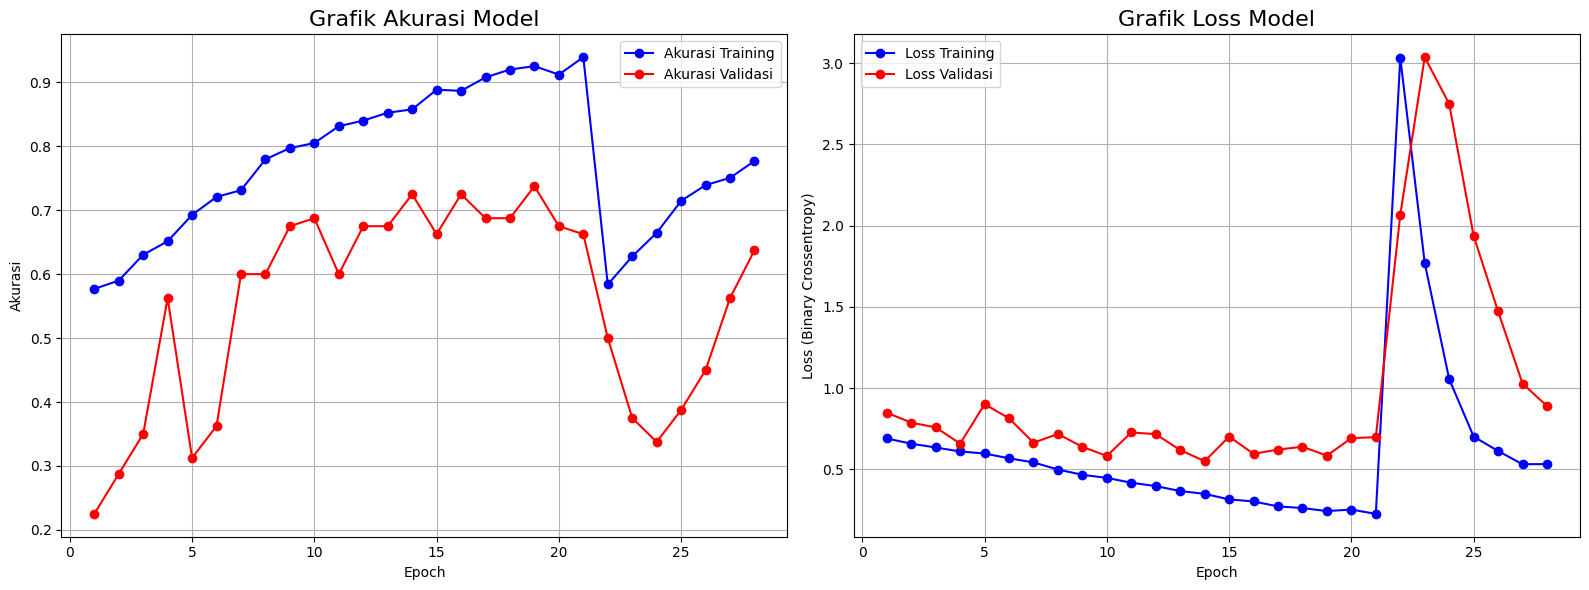

Berikut adalah grafik yang menampilkan Akurasi dan Loss selama proses training dan validasi.
Garis 'bo-' mewakili data training dan garis 'ro-' mewakili data validasi.

--- 2. Analisis Detail Kinerja pada Data Test ---
Membuat prediksi pada 134 sampel data test...


2025-09-20 08:36:38.085972: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 623ms/step

--- DIAGNOSA: Cek y_true dan y_pred_probs ---
Bentuk y_true: (134,)
Bentuk y_pred_probs: (134,)
Nilai unik di y_true: [0. 1.]
Jumlah sampel y_true Kelas 0: 30
Jumlah sampel y_true Kelas 1: 104

--- Distribusi Probabilitas Prediksi Kelas 1 (Prekursor) ---
Min prob: 0.0000
Max prob: 1.0000
Mean prob: 0.4505
Median prob: 0.4618


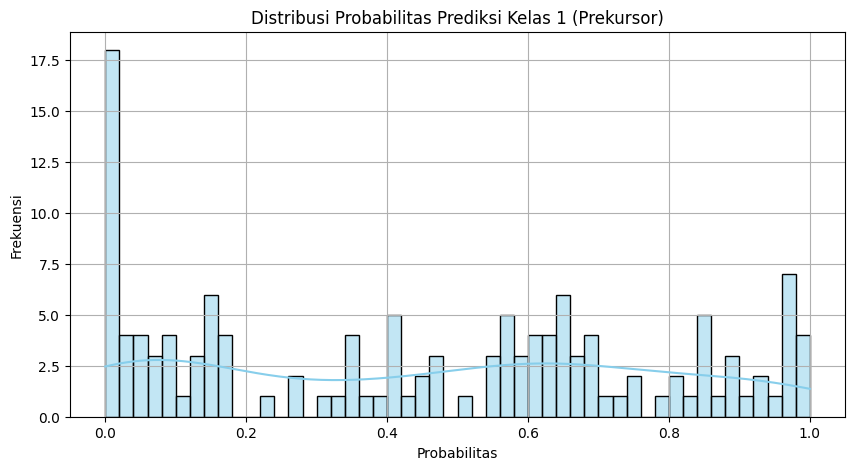

Jumlah prediksi probabilitas > 0.1: 101 dari 134
Jumlah sampel aktual Kelas 1 (Prekursor) di data test: 104
Nilai unik di y_pred (threshold 0.5): [0 1]
Jumlah prediksi y_pred Kelas 0 (threshold 0.5): 69
Jumlah prediksi y_pred Kelas 1 (threshold 0.5): 65

 a. Tabel Laporan Klasifikasi (Precision, Recall, F1-Score):
                     precision    recall  f1-score   support

   Normal (Kelas 0)       0.32      0.73      0.44        30
Prekursor (Kelas 1)       0.88      0.55      0.67       104

           accuracy                           0.59       134
          macro avg       0.60      0.64      0.56       134
       weighted avg       0.75      0.59      0.62       134


 b. Grafik Confusion Matrix:


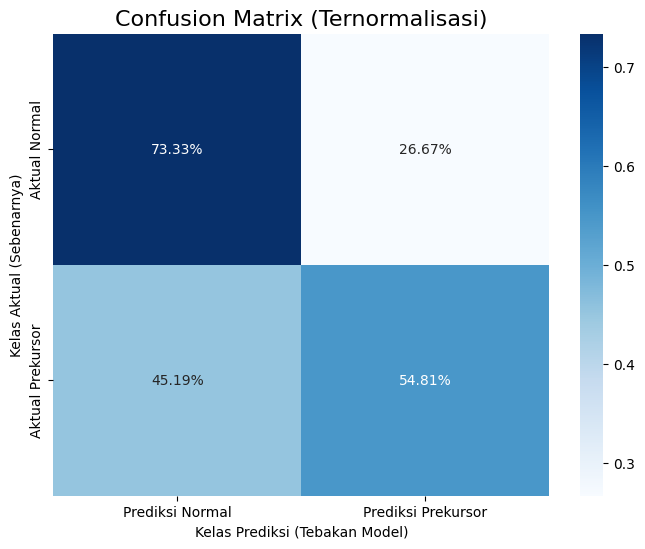


 c. Grafik Kurva ROC dan Nilai AUC:


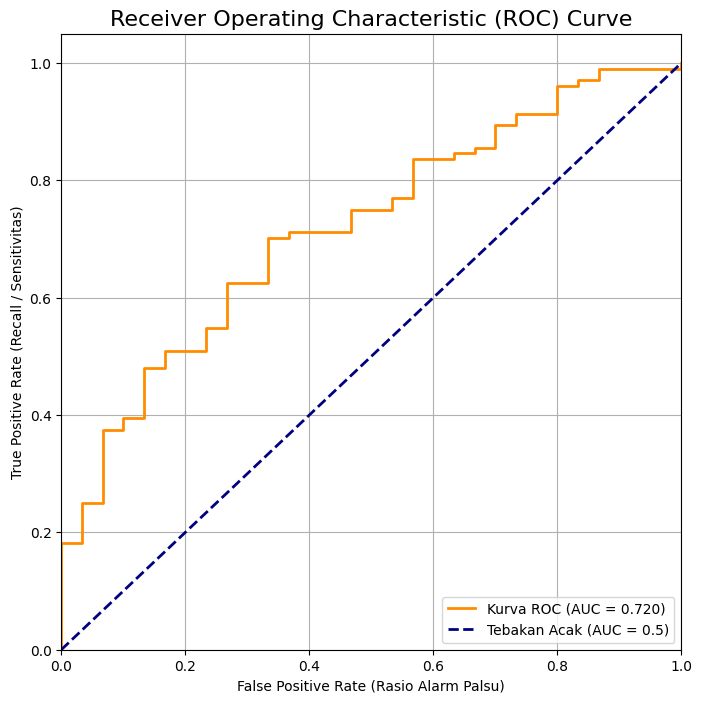


Nilai Area Under Curve (AUC): 0.7199
Semakin nilai AUC mendekati 1.0, semakin baik kemampuan model dalam membedakan kedua kelas.

 d. Analisis Kinerja pada Berbagai Ambang Batas Klasifikasi:
Threshold  P_Prec     R_Prec     F1_Prec    Accuracy  
0.10       0.83       0.81       0.82       0.72      
0.15       0.83       0.75       0.79       0.69      
0.20       0.85       0.71       0.77       0.68      
0.25       0.86       0.71       0.78       0.69      
0.30       0.87       0.70       0.78       0.69      
0.35       0.88       0.69       0.77       0.69      
0.40       0.87       0.63       0.73       0.64      
0.45       0.88       0.59       0.71       0.62      
0.50       0.88       0.55       0.67       0.59      
0.55       0.89       0.54       0.67       0.59      
0.60       0.92       0.47       0.62       0.56      
0.65       0.93       0.38       0.53       0.49      
0.70       0.94       0.29       0.44       0.43      
0.75       0.93       0.27       0.42 

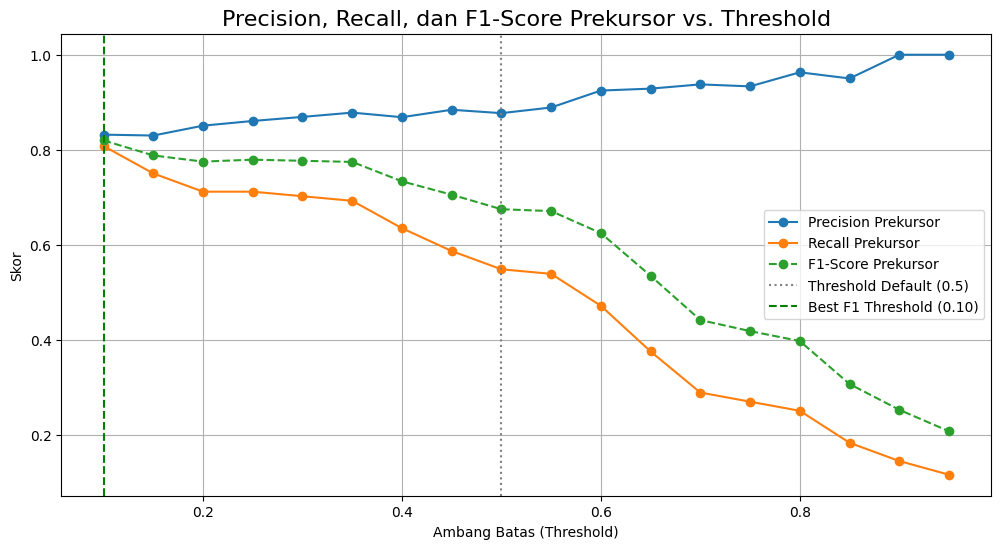


========================= LAPORAN SELESAI =========================


In [6]:
# ==============================================================================
# SEL 6: LAPORAN CEPAT DAN EVALUASI AKHIR
# ==============================================================================

# Pastikan semua library yang dibutuhkan untuk plotting sudah diimpor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import numpy as np
import tensorflow as tf
import pandas as pd 

# Bungkus semua dalam blok try-except untuk menangani NameError jika sel dijalankan tidak berurutan
try:
    # Cek apakah variabel riwayat pelatihan ada. Jika tidak, akan raise NameError.
    if 'history_head' not in locals() and 'history_fine_tune' not in locals():
        raise NameError("Variabel riwayat pelatihan (history_head/fine_tune) tidak ditemukan. Jalankan sel pelatihan (Sel 5) terlebih dahulu.")
    
    print(f"\n{'='*25} LAPORAN HASIL PEMODELAN {'='*25}")

    # Muat model terbaik yang disimpan selama pelatihan
    print(f"Memuat model terbaik dari: {MODEL_SAVE_PATH}")
    best_model = tf.keras.models.load_model(MODEL_SAVE_PATH)

    # ==============================================================================
    # BAGIAN 1: GRAFIK TRAINING DAN VALIDASI (AKURASI DAN LOSS)
    # ==============================================================================
    print("\n--- 1. Grafik Training dan Validasi (Akurasi dan Loss) ---")

    # Inisialisasi combined_history dengan list kosong
    combined_history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

    # Fungsi pembantu untuk menambahkan riwayat ke combined_history dengan aman
    def add_to_combined_history(source_history, target_history):
        if source_history is not None:
            for metric in ['accuracy', 'val_accuracy', 'loss', 'val_loss']:
                if metric in source_history.history:
                    target_history[metric].extend(source_history.history[metric])
                else:
                    print(f"Peringatan: Metrik '{metric}' tidak ditemukan di history ini.")

    # Tambahkan history dari tahap head (jika ada)
    if 'history_head' in locals():
        add_to_combined_history(history_head, combined_history)
    
    # Tambahkan history dari tahap fine_tune (jika ada)
    if 'history_fine_tune' in locals():
        add_to_combined_history(history_fine_tune, combined_history)

    def plot_training_history(history_dict):
        """Fungsi untuk membuat plot akurasi dan loss dari dictionary history."""
        acc = history_dict.get('accuracy')
        val_acc = history_dict.get('val_accuracy')
        loss = history_dict.get('loss')
        val_loss = history_dict.get('val_loss')
        
        if not acc or not val_acc or not loss or not val_loss:
            print("Tidak ada data lengkap untuk diplot (akurasi/loss mungkin kosong).")
            print("Periksa kembali riwayat pelatihan.")
            return

        epochs = range(1, len(acc) + 1)
        
        plt.figure(figsize=(16, 6))
        
        # Plot Akurasi
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'bo-', label='Akurasi Training')
        plt.plot(epochs, val_acc, 'ro-', label='Akurasi Validasi')
        plt.title('Grafik Akurasi Model', fontsize=16)
        plt.xlabel('Epoch')
        plt.ylabel('Akurasi')
        plt.grid(True)
        plt.legend()
        
        # Plot Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'bo-', label='Loss Training')
        plt.plot(epochs, val_loss, 'ro-', label='Loss Validasi')
        plt.title('Grafik Loss Model', fontsize=16)
        plt.xlabel('Epoch')
        plt.ylabel('Loss (Binary Crossentropy)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    # Panggil fungsi plotting
    plot_training_history(combined_history)
    print("Berikut adalah grafik yang menampilkan Akurasi dan Loss selama proses training dan validasi.")
    print("Garis 'bo-' mewakili data training dan garis 'ro-' mewakili data validasi.")
    
    # ==============================================================================
    # BAGIAN 2: ANALISIS DETAIL KINERJA PADA DATA TESTING
    # ==============================================================================
    print("\n--- 2. Analisis Detail Kinerja pada Data Test ---")
    
    # Kumpulkan semua gambar dan label dari test_dataset ke dalam list
    all_test_images = []
    all_test_labels = []
    for images, labels in test_dataset:
        all_test_images.append(images)
        all_test_labels.append(labels)
    
    y_true = np.array([])
    y_pred_probs = np.array([])

    if all_test_images: # Pastikan ada data test
        test_images_tensor = tf.concat(all_test_images, axis=0)
        test_labels_tensor = tf.concat(all_test_labels, axis=0)
        
        y_true = test_labels_tensor.numpy()
        print(f"Membuat prediksi pada {len(y_true)} sampel data test...")
        y_pred_probs = best_model.predict(test_images_tensor, verbose=1).flatten()
    else:
        print("Peringatan: test_dataset kosong. Tidak dapat melakukan evaluasi.")


    if len(y_true) > 0: # Lanjutkan hanya jika ada data test yang valid
        # --- DIAGNOSA ---
        print("\n--- DIAGNOSA: Cek y_true dan y_pred_probs ---")
        print(f"Bentuk y_true: {y_true.shape}")
        print(f"Bentuk y_pred_probs: {y_pred_probs.shape}")
        print(f"Nilai unik di y_true: {np.unique(y_true)}")
        print(f"Jumlah sampel y_true Kelas 0: {np.sum(y_true == 0)}")
        print(f"Jumlah sampel y_true Kelas 1: {np.sum(y_true == 1)}")
        
        print("\n--- Distribusi Probabilitas Prediksi Kelas 1 (Prekursor) ---")
        print(f"Min prob: {y_pred_probs.min():.4f}")
        print(f"Max prob: {y_pred_probs.max():.4f}")
        print(f"Mean prob: {y_pred_probs.mean():.4f}")
        print(f"Median prob: {np.median(y_pred_probs):.4f}")

        plt.figure(figsize=(10, 5))
        sns.histplot(y_pred_probs, bins=50, kde=True, color='skyblue')
        plt.title('Distribusi Probabilitas Prediksi Kelas 1 (Prekursor)')
        plt.xlabel('Probabilitas')
        plt.ylabel('Frekuensi')
        plt.grid(True)
        plt.show()

        num_above_0_1 = np.sum(y_pred_probs > 0.1)
        print(f"Jumlah prediksi probabilitas > 0.1: {num_above_0_1} dari {len(y_pred_probs)}")
        print(f"Jumlah sampel aktual Kelas 1 (Prekursor) di data test: {np.sum(y_true == 1)}")
        
        # Konversi probabilitas (0-1) menjadi kelas (0 atau 1) dengan ambang batas 0.5
        y_pred = (y_pred_probs > 0.5).astype(int)
        
        print(f"Nilai unik di y_pred (threshold 0.5): {np.unique(y_pred)}")
        print(f"Jumlah prediksi y_pred Kelas 0 (threshold 0.5): {np.sum(y_pred == 0)}")
        print(f"Jumlah prediksi y_pred Kelas 1 (threshold 0.5): {np.sum(y_pred == 1)}")


        # --- A. Tabel Laporan Klasifikasi ---
        print("\n a. Tabel Laporan Klasifikasi (Precision, Recall, F1-Score):")
        print(classification_report(y_true, y_pred, target_names=['Normal (Kelas 0)', 'Prekursor (Kelas 1)'], zero_division=0))

        # --- B. Grafik Confusion Matrix ---
        print("\n b. Grafik Confusion Matrix:")
        cm = confusion_matrix(y_true, y_pred)
        cm_normalized = np.zeros_like(cm, dtype=float)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_normalized[np.isnan(cm_normalized)] = 0 

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=['Prediksi Normal', 'Prediksi Prekursor'],
                    yticklabels=['Aktual Normal', 'Aktual Prekursor'])
        plt.title('Confusion Matrix (Ternormalisasi)', fontsize=16)
        plt.ylabel('Kelas Aktual (Sebenarnya)')
        plt.xlabel('Kelas Prediksi (Tebakan Model)')
        plt.show()

        # --- C. Grafik Kurva ROC & AUC ---
        print("\n c. Grafik Kurva ROC dan Nilai AUC:")
        auc_score = roc_auc_score(y_true, y_pred_probs)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (AUC = {auc_score:.3f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Tebakan Acak (AUC = 0.5)')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (Rasio Alarm Palsu)')
        plt.ylabel('True Positive Rate (Recall / Sensitivitas)')
        plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

        print(f"\nNilai Area Under Curve (AUC): {auc_score:.4f}")
        print("Semakin nilai AUC mendekati 1.0, semakin baik kemampuan model dalam membedakan kedua kelas.")
        
        # --- D. Analisis Ambang Batas Klasifikasi ---
        print("\n d. Analisis Kinerja pada Berbagai Ambang Batas Klasifikasi:")

        thresholds_range = np.arange(0.1, 1.0, 0.05) 
        
        best_f1_prec = -1 
        best_threshold = 0.5

        performance_data = []

        print("{:<10} {:<10} {:<10} {:<10} {:<10}".format("Threshold", "P_Prec", "R_Prec", "F1_Prec", "Accuracy"))

        for threshold in thresholds_range:
            y_pred_tuned = (y_pred_probs > threshold).astype(int)
            
            try:
                unique_preds = np.unique(y_pred_tuned)
                if len(unique_preds) == 1:
                    if unique_preds[0] == 0: 
                        p_prec = 0.0
                        r_prec = 0.0
                        f1_prec = 0.0
                        accuracy_tuned = np.mean(y_true == y_pred_tuned)
                    else: 
                        tp = np.sum((y_true == 1) & (y_pred_tuned == 1))
                        fp = np.sum((y_true == 0) & (y_pred_tuned == 1))
                        fn = np.sum((y_true == 1) & (y_pred_tuned == 0))
                        
                        p_prec = tp / (tp + fp + 1e-10) 
                        r_prec = tp / (tp + fn + 1e-10)
                        f1_prec = 2 * (p_prec * r_prec) / (p_prec + r_prec + 1e-10) if (p_prec + r_prec) > 0 else 0.0
                        accuracy_tuned = np.mean(y_true == y_pred_tuned)
                else: 
                    cr = classification_report(y_true, y_pred_tuned, output_dict=True, zero_division=0, labels=[0, 1])
                    p_prec = cr['1']['precision'] 
                    r_prec = cr['1']['recall']    
                    f1_prec = cr['1']['f1-score'] 
                    accuracy_tuned = cr['accuracy']
            except KeyError: 
                p_prec = 0.0
                r_prec = 0.0
                f1_prec = 0.0
                accuracy_tuned = np.mean(y_true == y_pred_tuned) 

            performance_data.append({
                'Threshold': threshold,
                'P_Prec': p_prec, 
                'R_Prec': r_prec, 
                'F1_Prec': f1_prec, 
                'Accuracy': accuracy_tuned
            })

            print("{:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f} {:<10.2f}".format(threshold, p_prec, r_prec, f1_prec, accuracy_tuned))

            if f1_prec > best_f1_prec: 
                best_f1_prec = f1_prec 
                best_threshold = threshold

        print(f"\nAmbang batas terbaik berdasarkan F1-score Prekursor: {best_threshold:.2f} (F1 = {best_f1_prec:.2f})")
        
        # Visualisasi Precision dan Recall vs. Threshold
        df_performance = pd.DataFrame(performance_data)

        plt.figure(figsize=(12, 6))
        plt.plot(df_performance['Threshold'], df_performance['P_Prec'], label='Precision Prekursor', marker='o')
        plt.plot(df_performance['Threshold'], df_performance['R_Prec'], label='Recall Prekursor', marker='o') 
        plt.plot(df_performance['Threshold'], df_performance['F1_Prec'], label='F1-Score Prekursor', marker='o', linestyle='--')
        plt.title('Precision, Recall, dan F1-Score Prekursor vs. Threshold', fontsize=16)
        plt.xlabel('Ambang Batas (Threshold)')
        plt.ylabel('Skor')
        plt.axvline(x=0.5, color='gray', linestyle=':', label='Threshold Default (0.5)')
        plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Best F1 Threshold ({best_threshold:.2f})')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("\nTidak ada data test yang cukup untuk melakukan evaluasi detail.")

    print(f"\n{'='*25} LAPORAN SELESAI {'='*25}")

except NameError as e:
    print(f"\n❌ EROR: Variabel yang dibutuhkan tidak ditemukan ({e}).")
    print("Pastikan Anda telah menjalankan sel pelatihan (Sel 5) hingga selesai pada sesi ini.")
except FileNotFoundError as e:
    print(f"\n❌ EROR: File model tidak ditemukan ({e}).")
    print(f"Pastikan model telah disimpan dengan benar di {MODEL_SAVE_PATH} setelah pelatihan.")
except Exception as e:
    print(f"\n❌ Terjadi kesalahan tak terduga: {e}")
    print("Periksa kembali pesan eror di atas untuk detail lebih lanjut.")